In [2]:
# 导入数据
# 对比四个简单的分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# select k best features
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 读取数据
data_label = pd.read_excel("./feature/class.xlsx", index_col=1)
data_label = data_label[data_label['exclusion'] == 1]
# index去掉.npy
data_label.index = data_label.index.str.replace('.npy', '')

tongji_label = data_label[data_label['dataset'] == 'tongji']["class"]
xiangyang_label = data_label[data_label['dataset'] == 'xiangyang']["class"]
kits_label = data_label[data_label['dataset'] == 'kits']["class"]
henan_label = data_label[data_label['dataset'] == 'henan']["class"]

tongji_rad = pd.read_excel('./feature/ring/ring_tongji.xlsx', index_col=0).iloc[:, 37:]
xiangyang_rad = pd.read_excel('./feature/ring/ring_xiangyang.xlsx', index_col=0).iloc[:, 22:]
kits_rad = pd.read_excel('./feature/ring/ring_kits.xlsx', index_col=0).iloc[:, 22:]
henan_rad = pd.read_excel('./feature/ring/ring_henan.xlsx', index_col=0).iloc[:, 22:]

# 合并数据表格
feature_rad = pd.concat([tongji_rad, xiangyang_rad], axis=0)
label = pd.concat([tongji_label, xiangyang_label], axis=0)

# 按照index排序
feature_rad = feature_rad.sort_index()
label = label.sort_index()

kits_rad = kits_rad.sort_index()
kits_label = kits_label.sort_index()

henan_rad = henan_rad.sort_index()
henan_label = henan_label.sort_index()

assert all(feature_rad.index == label.index)
assert all(kits_rad.index == kits_label.index)
assert all(henan_rad.index == henan_label.index)

# 定义 X_train, y_train, X_val, y_val
X_train, X_val, y_train, y_val = train_test_split(feature_rad, label, test_size=0.3, random_state=42)
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_henan = pd.DataFrame(scaler.transform(henan_rad), index=henan_rad.index, columns=henan_rad.columns)
X_kits = pd.DataFrame(scaler.transform(kits_rad), index=kits_rad.index, columns=kits_rad.columns)
y_henan = henan_label
y_kits = kits_label
assert all(X_kits.index == y_kits.index)
assert all(X_henan.index == y_henan.index)
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_henan = y_henan.values.ravel()
y_kits = y_kits.values.ravel()
# print(X_train.shape, y_train.shape)

In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.metrics import accuracy_score, matthews_corrcoef, auc, precision_score, recall_score
from scipy import stats

def bootstrap_ci(metric_func, y_prob, y_true, n_iterations=1000, ci=0.95):
    """
    使用bootstrap方法计算指标的置信区间
    
    参数：
    metric_func: 计算指标的函数
    y_prob: 预测概率
    y_true: 真实标签
    n_iterations: bootstrap迭代次数
    ci: 置信区间水平
    
    返回：
    tuple: (下界, 上界)
    """
    scores = []
    size = len(y_true)
    
    for _ in range(n_iterations):
        # 随机抽样
        indices = np.random.randint(0, size, size)
        score = metric_func(y_true[indices], y_prob[indices])
        scores.append(score)
    
    # 计算置信区间
    lower = np.percentile(scores, ((1-ci)/2)*100)
    upper = np.percentile(scores, (1-(1-ci)/2)*100)
    
    return round(lower, 3), round(upper, 3)

def calculate_metrics(y_prob, y_true):
    """
    计算不平衡二分类问题的评价指标，包括95%置信区间
    
    参数：
    y_prob: numpy array, 预测为正类(少数类)的概率值
    y_true: numpy array, 真实标签 (0为多数类，1为少数类)
    
    返回：
    dict: 包含评价指标和置信区间的字典
    """
    # 1. AUC
    auc_score = roc_auc_score(y_true, y_prob)
    auc_ci = bootstrap_ci(roc_auc_score, y_prob, y_true)
    
    # 2. 通过优化F1-score选择最佳阈值
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)
    best_threshold = thresholds[np.argmax(f1_scores[:-1])]
    
    # 使用最佳阈值进行预测
    y_pred = (y_prob >= best_threshold).astype(int)
    
    # 3. F1-score
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f1_ci = bootstrap_ci(lambda y_t, y_p: f1_score(y_t, (y_p >= best_threshold).astype(int)),
                        y_prob, y_true)
    
    # 4. ACC
    acc = accuracy_score(y_true, y_pred)
    acc_ci = bootstrap_ci(lambda y_t, y_p: accuracy_score(y_t, (y_p >= best_threshold).astype(int)),
                         y_prob, y_true)
    
    # 5. MCC
    mcc = matthews_corrcoef(y_true, y_pred)
    mcc_ci = bootstrap_ci(lambda y_t, y_p: matthews_corrcoef(y_t, (y_p >= best_threshold).astype(int)),
                         y_prob, y_true)
    
    # 6. AUPRC
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    
    def auprc_score(y_t, y_p):
        p, r, _ = precision_recall_curve(y_t, y_p)
        return auc(r, p)
    
    auprc_ci = bootstrap_ci(auprc_score, y_prob, y_true)
    
    # 7. Precision
    precisionscore = precision_score(y_true, y_pred)
    precision_ci = bootstrap_ci(lambda y_t, y_p: precision_score(y_t, (y_p >= best_threshold).astype(int)),
                              y_prob, y_true)

    # 8. Recall
    recallscore = recall_score(y_true, y_pred)
    recall_ci = bootstrap_ci(lambda y_t, y_p: recall_score(y_t, (y_p >= best_threshold).astype(int)),
                            y_prob, y_true)

    metrics = {
        'AUC': round(auc_score, 3),
        'AUC_CI': auc_ci,
        'F1': round(f1, 3),
        'F1_CI': f1_ci,
        'ACC': round(acc, 3),
        'ACC_CI': acc_ci,
        'MCC': round(mcc, 3),
        'MCC_CI': mcc_ci,
        'AUPRC': round(auprc, 3),
        'AUPRC_CI': auprc_ci,
        'threshold': round(best_threshold, 3),
        'Precision': round(precisionscore, 3),
        'Precision_CI': precision_ci,
        'Recall': round(recallscore, 3),
        'Recall_CI': recall_ci
    }
    return metrics

def format_metrics(metrics):
    """
    格式化指标输出，包含置信区间
    """
    formatted = {}
    for key in metrics:
        if key.endswith('_CI'):
            continue
        if key + '_CI' in metrics:
            formatted[key] = f"{metrics[key]} ({metrics[key+'_CI'][0]}-{metrics[key+'_CI'][1]})"
        else:
            formatted[key] = f"{metrics[key]}"
    
    return formatted


# # 使用示例
# if __name__ == "__main__":
#     # 生成示例数据（9:1的不平衡数据）
#     np.random.seed(42)
#     y_true = np.array([0] * 90 + [1] * 10)
#     y_prob = np.random.random(100)
    
#     # 计算指标
#     metrics = calculate_metrics(y_prob, y_true)
    
#     # 打印结果
#     for metric_name, value in metrics.items():
#         print(f"{metric_name}: {value}")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

def calculate_metrics(y_proba: np.ndarray, y_true: np.ndarray) -> Dict:
    """
    计算模型评估指标
    
    Parameters:
    -----------
    y_proba : array-like
        预测的概率值
    y_true : array-like
        真实标签
    
    Returns:
    --------
    dict : 包含各项评估指标的字典
    """
    y_pred = (y_proba >= 0.5).astype(int)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_proba)
    }

def create_classifiers() -> Dict:
    """创建分类器字典"""
    return {
        'logistic_regression': LogisticRegression(class_weight='balanced'),
        'decision_tree': DecisionTreeClassifier(class_weight='balanced'),
        'random_forest': RandomForestClassifier(class_weight='balanced'),
        'svm': SVC(class_weight='balanced', probability=True)
    }

def create_param_grids() -> Dict:
    """创建参数网格字典"""
    return {
        'logistic_regression': {
            'classifier__C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
            'classifier__penalty': ['l1', 'l2'],  # 使用l1正则化
            # 'classifier__solver': ['liblinear'],  # liblinear对于l1更快更稳定
            'classifier__max_iter': [2000],
            'classifier__tol': [1e-4],
        },
        'decision_tree': {
            'classifier__criterion': ['gini'],  # gini更常用
            'classifier__max_depth': [3, 4, 5, 6],
            'classifier__min_samples_split': [4, 5, 6, 7, 8],
            'classifier__min_samples_leaf': [1, 2, 3]
        },
        'random_forest': {
            'classifier__n_estimators': [85, 90, 95, 100, 105, 110, 115],  # 更细致地围绕100
            'classifier__max_depth': [3, 4, 5],  # 保持不变，因为4表现最好
            'classifier__min_samples_split': [4, 5, 6, 7],  # 围绕5
            'classifier__min_samples_leaf': [1, 2],  # 控制叶节点大小
            'classifier__max_features': ['sqrt'],  # 最常用的选择
            'classifier__max_samples': [0.8, 0.9, 1.0]  # 控制每棵树的样本量
        },
        'svm': {
            'classifier__C': [0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12],  # 更细致地围绕0.08-0.1
            'classifier__kernel': ['linear'],  # 线性核表现最好
            'classifier__gamma': ['scale']  # 保持默认
        }
    }

def evaluate_model(model, X: np.ndarray, y: np.ndarray, dataset_name: str) -> Optional[Dict]:
    """
    评估模型性能
    
    Parameters:
    -----------
    model : 训练好的模型
    X : array-like
        特征矩阵
    y : array-like
        标签向量
    dataset_name : str
        数据集名称
    
    Returns:
    --------
    Optional[Dict] : 包含评估指标的字典，如果评估失败则返回None
    """
    try:
        y_proba = model.predict_proba(X)[:, 1]
        metrics = calculate_metrics(y_proba, y)
        metrics['dataset'] = dataset_name
        return metrics
    except Exception as e:
        print(f"Error evaluating {dataset_name}: {str(e)}")
        return None

def run_grid_search(X_train: np.ndarray, y_train: np.ndarray, 
                   X_val: np.ndarray, y_val: np.ndarray, 
                   X_henan: np.ndarray, y_henan: np.ndarray, 
                   X_kits: np.ndarray, y_kits: np.ndarray, 
                   selected_classifiers: Optional[List[str]] = None, 
                   k_range: range = range(20, 40, 1)) -> pd.DataFrame:
    """
    运行网格搜索并评估模型
    
    Parameters:
    -----------
    X_train, y_train : 训练数据
    X_val, y_val : 验证数据
    X_henan, y_henan : 河南数据集
    X_kits, y_kits : KITS数据集
    selected_classifiers : 要评估的分类器列表
    k_range : 特征选择的k值范围
    
    Returns:
    --------
    pd.DataFrame : 评估结果表格
    """
    classifiers = create_classifiers()
    param_grids = create_param_grids()
    results = []
    
    if selected_classifiers:
        classifiers = {k: v for k, v in classifiers.items() if k in selected_classifiers}
    
    for k_num in k_range:
        for clf_name, clf in classifiers.items():
            print(f"\nProcessing k={k_num}, classifier={clf_name}")
            
            try:
                pipeline = Pipeline([
                    ('feature_selection', SelectKBest(mutual_info_classif, k=k_num)),
                    ('classifier', clf)
                ])
                
                grid_search = GridSearchCV(
                    pipeline,
                    param_grid=param_grids[clf_name],
                    cv=5,
                    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                    refit='roc_auc',
                    n_jobs=-1,
                    verbose=1
                )
                
                grid_search.fit(X_train, y_train)
                
                base_result = {
                    'k_num': k_num,
                    'classifier': clf_name,
                    'best_params': str(grid_search.best_params_),
                    'best_score': grid_search.best_score_
                }
                
                datasets = {
                    'validation': (X_val, y_val),
                    'henan': (X_henan, y_henan),
                    'kits': (X_kits, y_kits)
                }
                
                for dataset_name, (X, y) in datasets.items():
                    metrics = evaluate_model(grid_search.best_estimator_, X, y, dataset_name)
                    if metrics:
                        result = base_result.copy()
                        result.update(metrics)
                        results.append(result)
                
            except Exception as e:
                print(f"Error processing {clf_name} with k={k_num}: {str(e)}")
                continue
    
    results_df = pd.DataFrame(results)
    
    try:
        results_df.to_excel('model_evaluation_results0.xlsx', index=False)
        print("\nResults saved to 'model_evaluation_results.xlsx'")
    except Exception as e:
        print(f"Error saving results: {str(e)}")
        results_df.to_csv('model_evaluation_results0.csv', index=False)
        print("Results saved to 'model_evaluation_results.csv' instead")
    
    return results_df

# 使用示例
results_df = run_grid_search(X_train, y_train, X_val, y_val, X_henan, y_henan, X_kits, y_kits)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np

classifier = LogisticRegression(
        C=0.5,
        max_iter=2000,
        penalty='l2',
        tol=0.0001,
        random_state=42,
        class_weight='balanced'
)

# 2. 构建pipeline
pipeline = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=39)),
    ('classifier', classifier)
])

# 3. 训练模型
pipeline.fit(X_train, y_train)

# 4. 在训练集上评估
train_pred_proba = pipeline.predict_proba(X_train)[:, 1]
# train_pred = pipeline.predict(X_train)

# 4. 在验证集上评估
val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
# val_pred = pipeline.predict(X_val)

# 5. 在两个测试集上评估
henan_pred_proba = pipeline.predict_proba(X_henan)[:, 1]
# henan_pred = pipeline.predict(X_henan)

kits_pred_proba = pipeline.predict_proba(X_kits)[:, 1]
# kits_pred = pipeline.predict(X_kits)

# 6. 计算各项指标
result_train = calculate_metrics(train_pred_proba, y_train)
result_val = calculate_metrics(val_pred_proba, y_val)
result_henan = calculate_metrics(henan_pred_proba, y_henan)
result_kits = calculate_metrics(kits_pred_proba, y_kits)
print(result_train)
print(result_val)
print(result_henan)
print(result_kits)

# # 运行模型评估
# build_and_evaluate_model(
#     X_train, y_train, 
#     X_val, y_val,
#     X_henan, y_henan, 
#     X_kits, y_kits
# )

{'AUC': 0.786, 'AUC_CI': (0.725, 0.842), 'F1': 0.426, 'F1_CI': (0.31, 0.532), 'ACC': 0.873, 'ACC_CI': (0.846, 0.9), 'MCC': 0.355, 'MCC_CI': (0.23, 0.47), 'AUPRC': 0.326, 'AUPRC_CI': (0.226, 0.457), 'threshold': 0.669, 'Precision': 0.433, 'Precision_CI': (0.3, 0.563), 'Recall': 0.419, 'Recall_CI': (0.308, 0.535)}
{'AUC': 0.648, 'AUC_CI': (0.52, 0.762), 'F1': 0.316, 'F1_CI': (0.154, 0.471), 'ACC': 0.835, 'ACC_CI': (0.785, 0.882), 'MCC': 0.229, 'MCC_CI': (0.043, 0.4), 'AUPRC': 0.176, 'AUPRC_CI': (0.099, 0.306), 'threshold': 0.687, 'Precision': 0.273, 'Precision_CI': (0.125, 0.432), 'Recall': 0.375, 'Recall_CI': (0.167, 0.572)}
{'AUC': 0.608, 'AUC_CI': (0.503, 0.711), 'F1': 0.396, 'F1_CI': (0.277, 0.509), 'ACC': 0.642, 'ACC_CI': (0.572, 0.706), 'MCC': 0.168, 'MCC_CI': (0.029, 0.319), 'AUPRC': 0.459, 'AUPRC_CI': (0.314, 0.587), 'threshold': 0.537, 'Precision': 0.324, 'Precision_CI': (0.21, 0.429), 'Recall': 0.512, 'Recall_CI': (0.351, 0.657)}
{'AUC': 0.584, 'AUC_CI': (0.485, 0.691), 'F1': 0

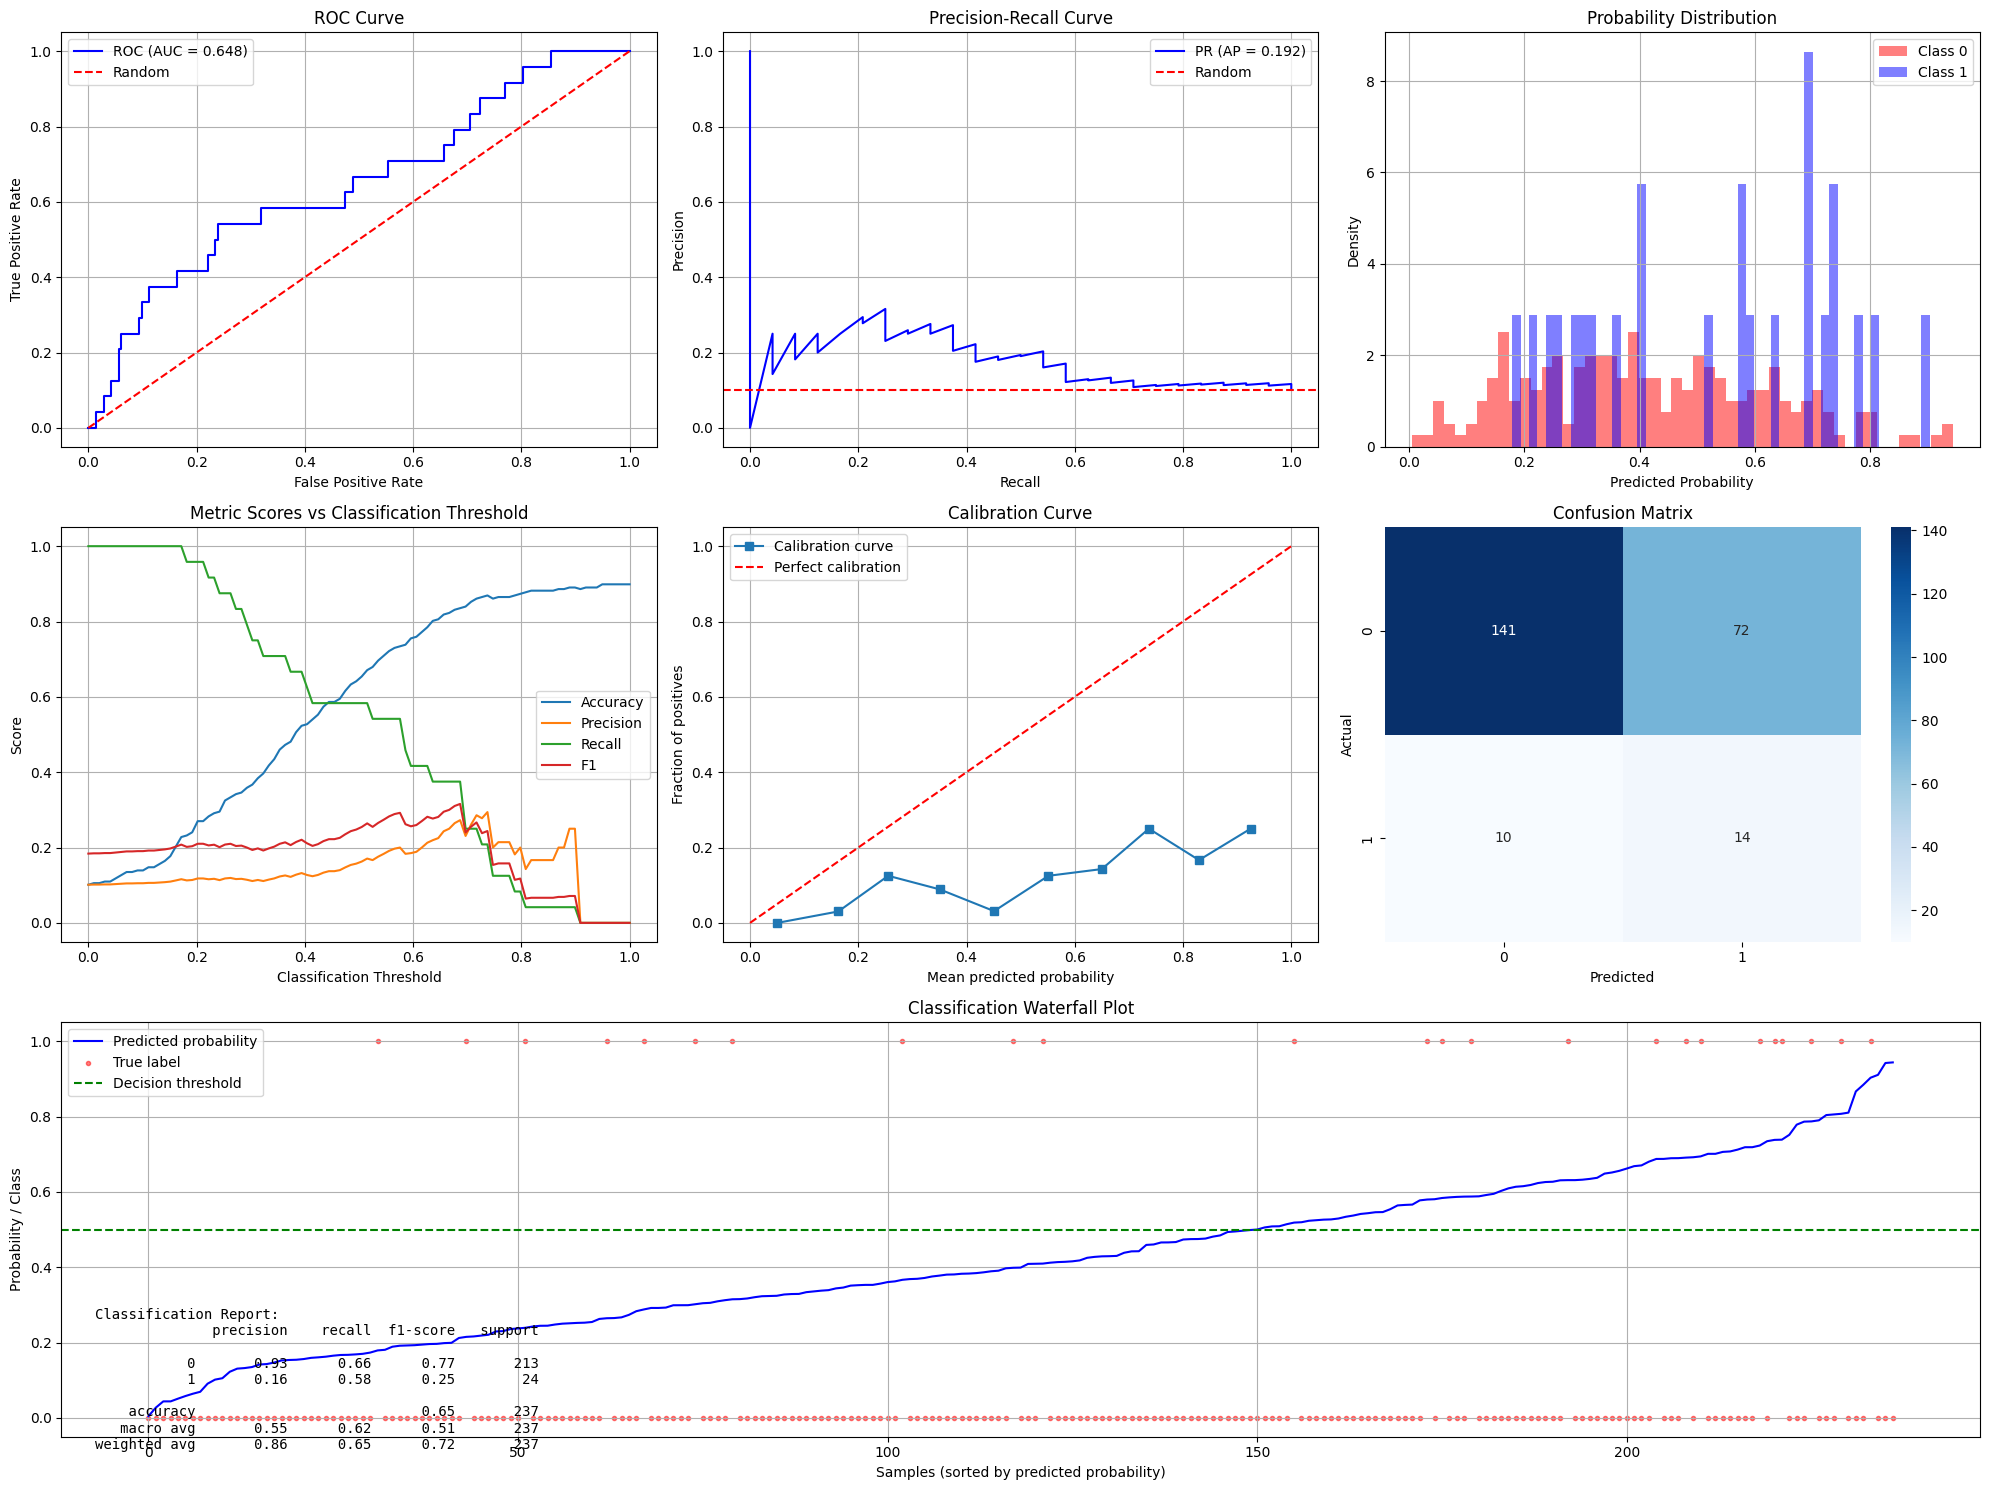

AUC: 0.6480829420970267
Average Precision: 0.19196185278160327

Confusion Matrix:
[[141  72]
 [ 10  14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       213
           1       0.16      0.58      0.25        24

    accuracy                           0.65       237
   macro avg       0.55      0.62      0.51       237
weighted avg       0.86      0.65      0.72       237



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, precision_recall_curve, average_precision_score,
                           roc_auc_score, confusion_matrix, classification_report)
from sklearn.calibration import calibration_curve

def plot_classifier_evaluation(y_true, y_prob, figsize=(20, 15)):
    """
    综合的分类器评估可视化函数
    
    参数:
    y_true: 真实标签 (0/1)
    y_prob: 预测概率 (对正类的预测概率)
    figsize: 图形大小
    """
    # 创建子图
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3)
    
    # 1. ROC曲线
    ax1 = fig.add_subplot(gs[0, 0])
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    
    ax1.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'r--', label='Random')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True)
    
    # 2. PR曲线
    ax2 = fig.add_subplot(gs[0, 1])
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    
    ax2.plot(recall, precision, 'b-', label=f'PR (AP = {ap:.3f})')
    ax2.axhline(y=sum(y_true)/len(y_true), color='r', linestyle='--', 
                label='Random')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True)
    
    # 3. 预测概率分布
    ax3 = fig.add_subplot(gs[0, 2])
    for label, color in zip([0, 1], ['red', 'blue']):
        mask = y_true == label
        ax3.hist(y_prob[mask], bins=50, density=True, alpha=0.5, 
                color=color, label=f'Class {label}')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Probability Distribution')
    ax3.legend()
    ax3.grid(True)
    
    # 4. 分类阈值分析
    ax4 = fig.add_subplot(gs[1, 0])
    thresholds = np.linspace(0, 1, 100)
    scores = []
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        scores.append([accuracy, precision, recall, f1])
    
    scores = np.array(scores)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    for i, metric in enumerate(metrics):
        ax4.plot(thresholds, scores[:, i], label=metric)
    ax4.set_xlabel('Classification Threshold')
    ax4.set_ylabel('Score')
    ax4.set_title('Metric Scores vs Classification Threshold')
    ax4.legend()
    ax4.grid(True)
    
    # 5. 校准曲线
    ax5 = fig.add_subplot(gs[1, 1])
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    ax5.plot(prob_pred, prob_true, 's-', label='Calibration curve')
    ax5.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')
    ax5.set_xlabel('Mean predicted probability')
    ax5.set_ylabel('Fraction of positives')
    ax5.set_title('Calibration Curve')
    ax5.legend()
    ax5.grid(True)
    
    # 6. 混淆矩阵
    ax6 = fig.add_subplot(gs[1, 2])
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax6)
    ax6.set_xlabel('Predicted')
    ax6.set_ylabel('Actual')
    ax6.set_title('Confusion Matrix')
    
    # 7. 分类瀑布图
    ax7 = fig.add_subplot(gs[2, :])
    
    # 按预测概率排序
    sorted_indices = np.argsort(y_prob)
    sorted_probs = y_prob[sorted_indices]
    sorted_true = y_true[sorted_indices]
    
    # 创建瀑布图
    ax7.plot(range(len(sorted_probs)), sorted_probs, 'b-', label='Predicted probability')
    ax7.scatter(range(len(sorted_true)), sorted_true, c='r', alpha=0.5, 
               label='True label', marker='.')
    ax7.axhline(y=0.5, color='g', linestyle='--', label='Decision threshold')
    ax7.set_xlabel('Samples (sorted by predicted probability)')
    ax7.set_ylabel('Probability / Class')
    ax7.set_title('Classification Waterfall Plot')
    ax7.legend()
    ax7.grid(True)
    
    # 添加分类报告为文本
    report = classification_report(y_true, y_pred)
    fig.text(0.05, 0.02, f'Classification Report:\n{report}', 
             fontfamily='monospace', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 返回主要评估指标
    return {
        'AUC': auc,
        'AP': ap,
        'Confusion Matrix': cm,
        'Classification Report': classification_report(y_true, y_pred)
    }

# 假设你有预测概率和真实标签
y_true = y_val              # 真实标签 (0/1)
y_prob = val_pred_proba     # 预测概率

# 调用函数
metrics = plot_classifier_evaluation(y_true, y_prob)

# 打印评估指标
print("AUC:", metrics['AUC'])
print("Average Precision:", metrics['AP'])
print("\nConfusion Matrix:")
print(metrics['Confusion Matrix'])
print("\nClassification Report:")
print(metrics['Classification Report'])

In [ ]:
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
def analyze_feature_selection(pipeline, feature_names):
    # 获取选中的特征
    selector = pipeline.named_steps['feature_selection']
    selected_mask = selector.get_support()
    selected_features = feature_names[selected_mask]
    
    # 获取互信息分数
    scores = selector.scores_
    
    # 创建特征重要性DataFrame
    feature_scores = pd.DataFrame({
        'Feature': feature_names,
        'Selected': selected_mask,
        'Mutual_Info_Score': scores
    })
    
    # 排序并显示结果
    feature_scores = feature_scores.sort_values('Mutual_Info_Score', ascending=False)
    
    # 绘制互信息分数图
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(selected_features)), 
            feature_scores[feature_scores['Selected']]['Mutual_Info_Score'])
    plt.xticks(range(len(selected_features)), 
               feature_scores[feature_scores['Selected']]['Feature'], 
               rotation=45, ha='right')
    plt.title('Mutual Information Scores of Selected Features')
    plt.tight_layout()
    plt.show()
    
    return feature_scores

def analyze_shap_values(pipeline, X_train, feature_names):
    # 获取选中的特征和模型
    selected_features_mask = pipeline.named_steps['feature_selection'].get_support()
    selected_features = feature_names[selected_features_mask]
    
    # 如果X_train是DataFrame，需要正确地选择特征
    if isinstance(X_train, pd.DataFrame):
        X_selected = X_train.iloc[:, selected_features_mask].values
    else:
        X_selected = X_train[:, selected_features_mask]
    
    rf_model = pipeline.named_steps['classifier']
    
    # 创建SHAP解释器
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_selected)
    
    # 对于二分类问题，选择正类的SHAP值
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_selected, 
                     feature_names=selected_features.tolist(),
                     show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()
    
    # SHAP依赖图（针对top 3特征）
    mean_abs_shap = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(mean_abs_shap)[-3:]
    
    for idx in top_features_idx:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(idx, shap_values, X_selected,
                           feature_names=selected_features.tolist(),
                           show=False)
        plt.title(f'SHAP Dependence Plot - {selected_features[idx]}')
        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame({
        'Feature': selected_features,
        'Mean_abs_shap': mean_abs_shap
    }).sort_values('Mean_abs_shap', ascending=False)

def analyze_feature_selection(pipeline, feature_names):
    # 获取选中的特征
    selector = pipeline.named_steps['feature_selection']
    selected_mask = selector.get_support()
    selected_features = feature_names[selected_mask]
    
    # 获取互信息分数
    scores = selector.scores_
    
    # 创建特征重要性DataFrame
    feature_scores = pd.DataFrame({
        'Feature': feature_names,
        'Selected': selected_mask,
        'Mutual_Info_Score': scores
    })
    
    # 排序并显示结果
    feature_scores = feature_scores.sort_values('Mutual_Info_Score', ascending=False)
    
    # 绘制互信息分数图
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(selected_features)), 
            feature_scores[feature_scores['Selected']]['Mutual_Info_Score'])
    plt.xticks(range(len(selected_features)), 
               feature_scores[feature_scores['Selected']]['Feature'], 
               rotation=45, ha='right')
    plt.title('Mutual Information Scores of Selected Features')
    plt.tight_layout()
    plt.show()
    
    return feature_scores

def analyze_rf_importance(pipeline, feature_names):
    # 获取选中的特征和模型
    selected_features_mask = pipeline.named_steps['feature_selection'].get_support()
    selected_features = feature_names[selected_features_mask]
    rf_model = pipeline.named_steps['classifier']
    
    # 获取并排序特征重要性
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    
    # 创建DataFrame
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances,
        'Std': std
    }).sort_values('Importance', ascending=False)
    
    # 绘制特征重要性及其标准差
    plt.figure(figsize=(12, 6))
    feature_importance.plot(kind='bar', x='Feature', y='Importance', yerr='Std',
                          capsize=5, alpha=0.8)
    plt.title('Random Forest Feature Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def comprehensive_model_interpretation(pipeline, X_train, y_train, X_val, y_val, feature_names):
    print("=== 特征选择分析 ===")
    feature_selection_results = analyze_feature_selection(pipeline, feature_names)
    print("\n选中的特征数量:", feature_selection_results['Selected'].sum())
    print("\nTop 10 features by mutual information:")
    print(feature_selection_results.head(10))
    
    print("\n=== Random Forest特征重要性分析 ===")
    rf_importance = analyze_rf_importance(pipeline, feature_names)
    print("\nTop 10 features by RF importance:")
    print(rf_importance.head(10))
    
    print("\n=== SHAP值分析 ===")
    shap_importance = analyze_shap_values(pipeline, X_train, feature_names)
    print("\nTop 10 features by SHAP importance:")
    print(shap_importance.head(10))
    
    # 合并所有重要性指标
    final_importance = pd.merge(
        feature_selection_results[feature_selection_results['Selected']],
        rf_importance,
        on='Feature',
        how='outer'
    )
    final_importance = pd.merge(
        final_importance,
        shap_importance,
        on='Feature',
        how='outer'
    )
    
    return final_importance

# 使用示例
results = comprehensive_model_interpretation(
    pipeline,
    X_train, y_train,
    X_val, y_val,
    np.array(X_train.columns)
)

# 保存结果到CSV
results.to_csv('feature_importance_analysis.csv', index=False)

=== 开始模型解释分析 ===

Model AUC Score: 0.6481


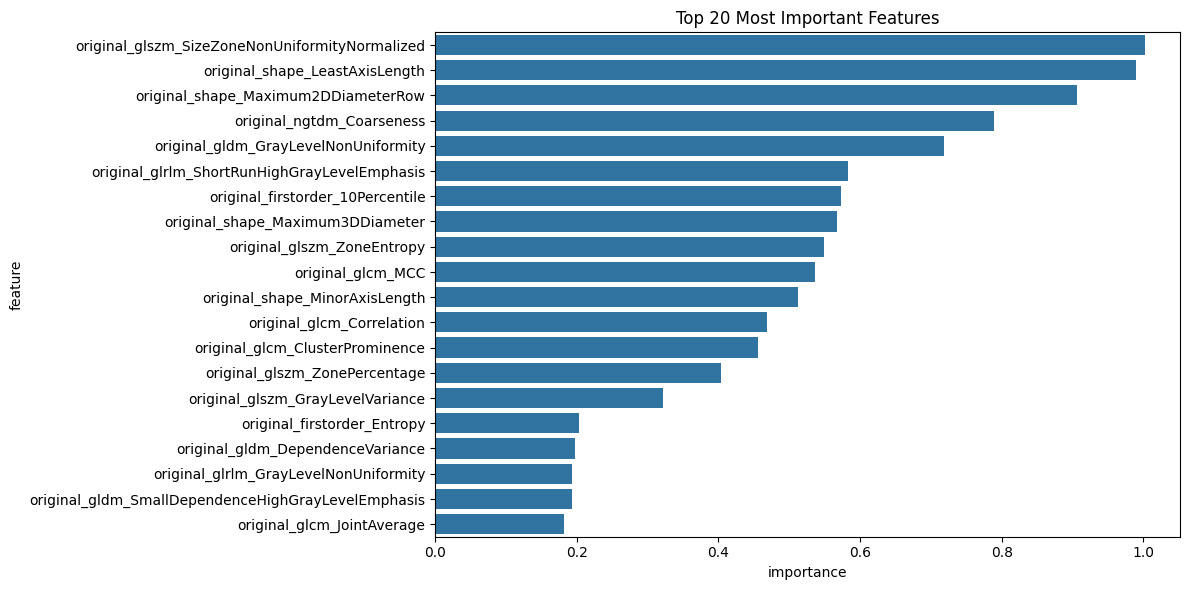

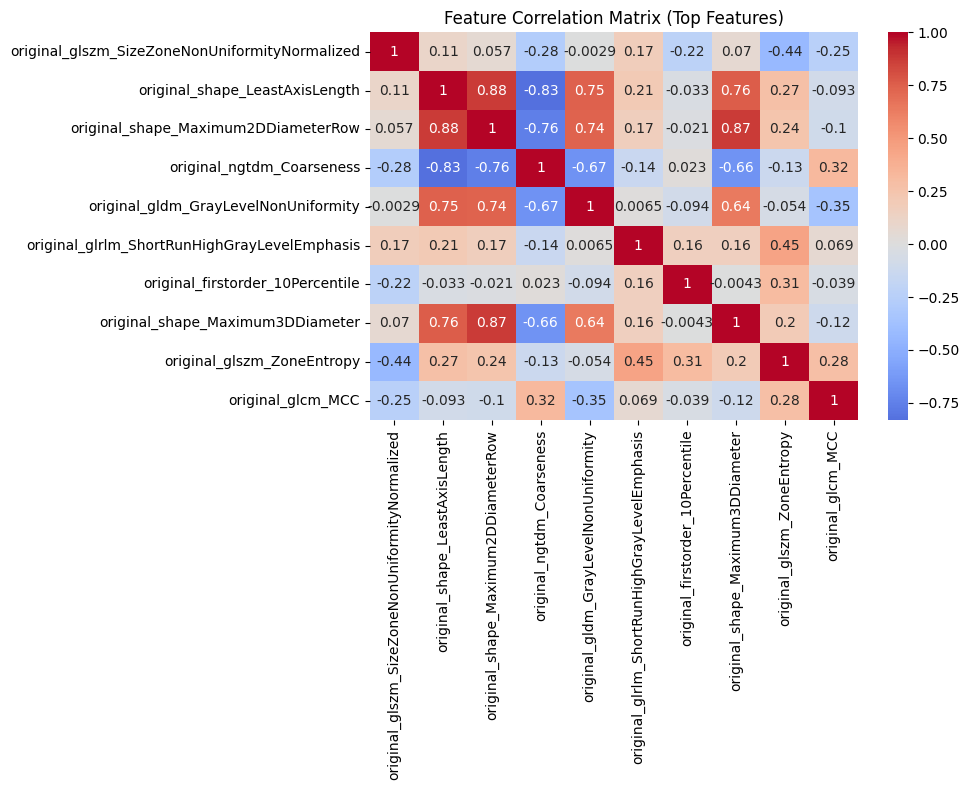


=== SHAP Values Analysis ===


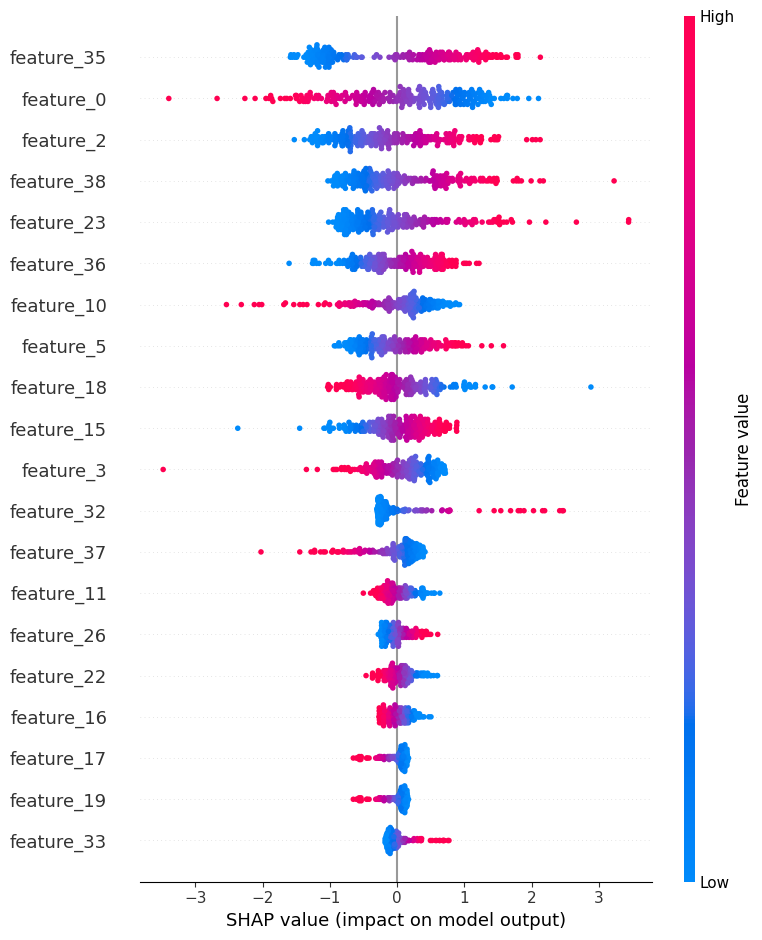

<Figure size 800x600 with 0 Axes>

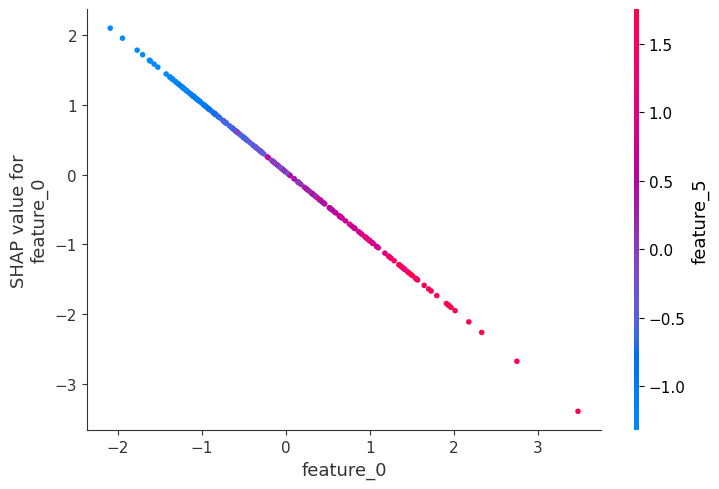

<Figure size 800x600 with 0 Axes>

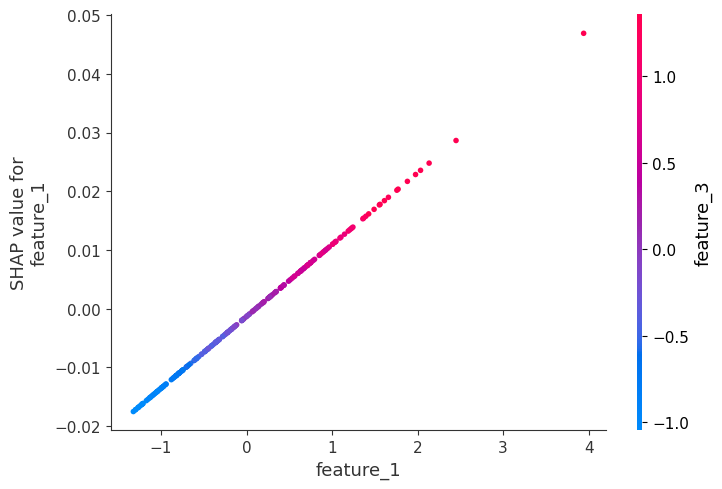

<Figure size 800x600 with 0 Axes>

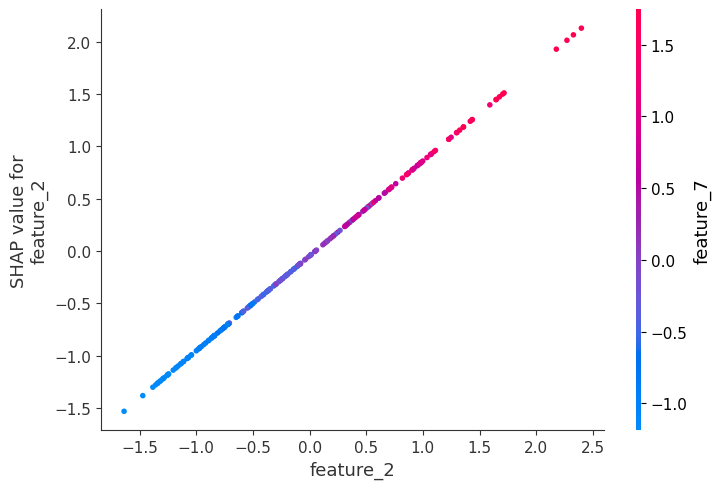


=== Partial Dependence Plots ===


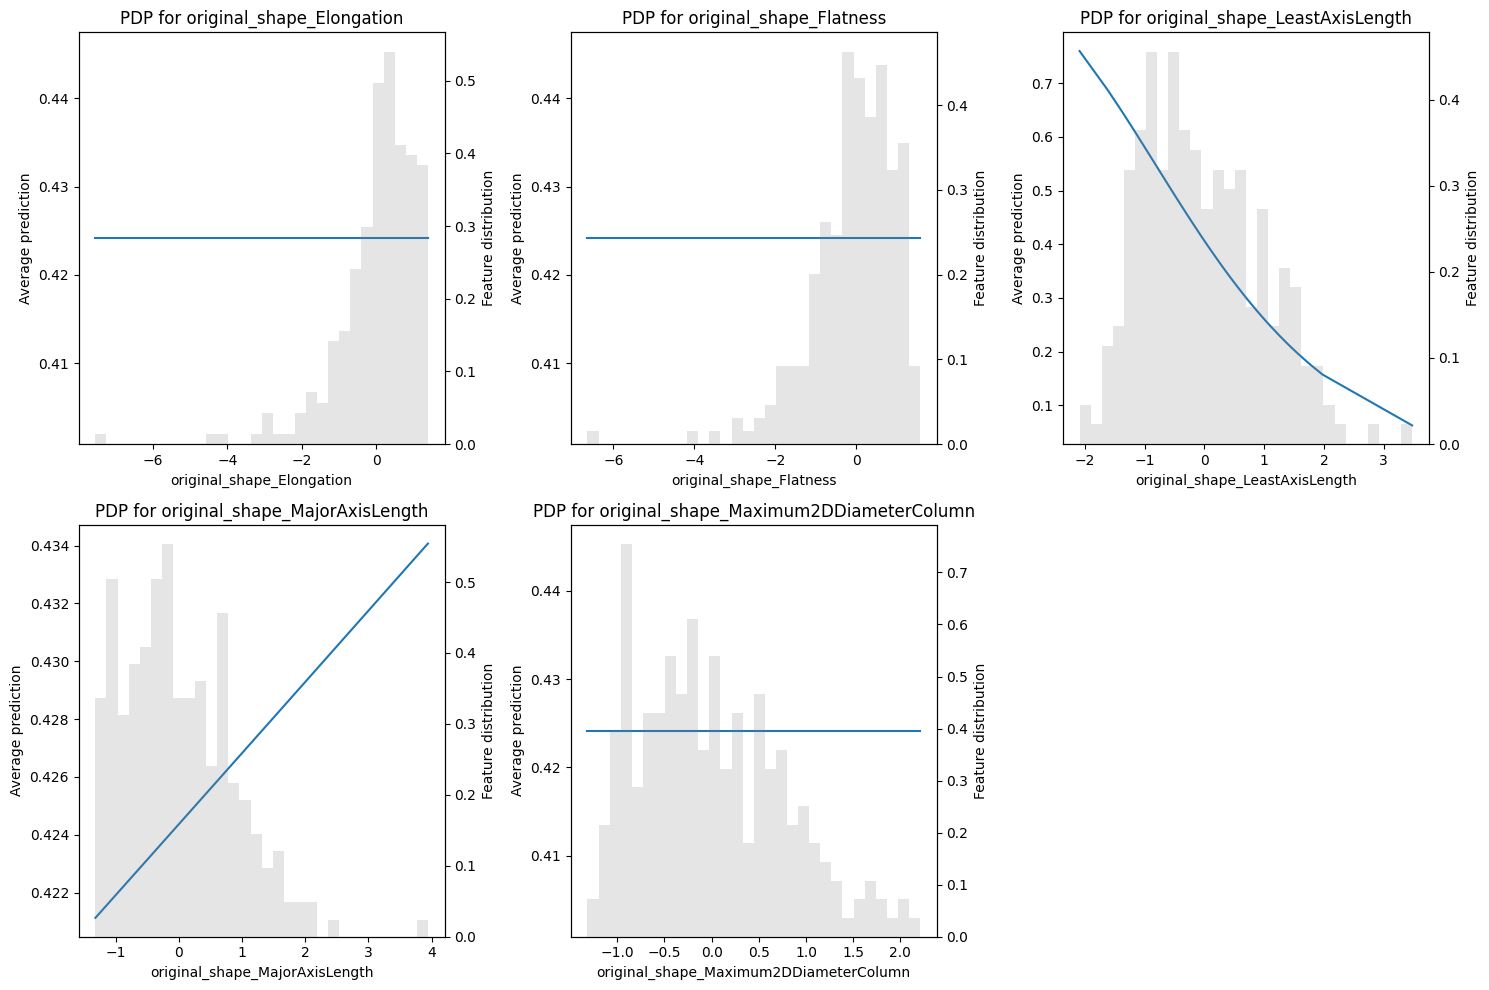

In [11]:
import numpy as np
import pandas as pd
import shap
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ... [previous functions remain the same until analyze_shap_values] ...

def analyze_shap_values(pipeline, X, feature_names):
    """分析SHAP值"""
    # 首先通过pipeline转换数据
    X_transformed = X
    for name, step in pipeline.named_steps.items():
        if name != 'classifier':
            try:
                X_transformed = step.transform(X_transformed)
            except:
                continue
    
    model = pipeline.named_steps['classifier']
    
    # 确保feature_names长度匹配转换后的特征数量
    if isinstance(X_transformed, np.ndarray):
        X_transformed = pd.DataFrame(X_transformed, columns=[f'feature_{i}' for i in range(X_transformed.shape[1])])
    
    # 创建SHAP解释器
    if hasattr(model, 'estimators_'):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.LinearExplainer(model, X_transformed)
    
    shap_values = explainer.shap_values(X_transformed)
    
    # 如果是多分类问题，取第一个类别的SHAP值
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # 使用转换后的特征名
    feature_names_transformed = X_transformed.columns
    
    # SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_transformed, 
                     feature_names=feature_names_transformed, 
                     show=False)
    plt.tight_layout()
    plt.show()
    
    # SHAP依赖图（对前几个最重要的特征）
    for feature in feature_names_transformed[:3]:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(
            feature, 
            shap_values, 
            X_transformed,
            feature_names=feature_names_transformed,
            show=False
        )
        plt.tight_layout()
        plt.show()

def plot_pdp(pipeline, X, feature_names, top_n=5):
    """绘制部分依赖图"""
    # 首先通过pipeline转换数据
    X_transformed = X.copy()  # 创建副本避免修改原始数据
    feature_names_transformed = None
    
    for name, step in pipeline.named_steps.items():
        if name != 'classifier':
            try:
                X_transformed = step.transform(X_transformed)
                if hasattr(step, 'get_feature_names_out'):
                    feature_names_transformed = step.get_feature_names_out()
            except:
                continue
    
    if feature_names_transformed is None:
        feature_names_transformed = feature_names
    
    if isinstance(X_transformed, np.ndarray):
        X_transformed = pd.DataFrame(X_transformed, columns=feature_names_transformed)
    
    model = pipeline.named_steps['classifier']
    
    # 使用原始特征的前top_n个
    top_features = feature_names[:top_n]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, feature in enumerate(top_features):
        if idx >= len(axes):
            break
            
        try:
            # 获取特征的值范围
            feature_values = X[feature].values
            percentiles = np.percentile(feature_values, np.linspace(0, 100, num=50))
            
            # 创建特征网格
            feature_grid = np.unique(percentiles)
            
            # 存储每个网格点的预测值
            pdp_values = []
            
            # 对每个网格点计算平均预测值
            for grid_value in feature_grid:
                X_temp = X.copy()
                X_temp[feature] = grid_value
                pred = pipeline.predict_proba(X_temp)[:, 1]
                pdp_values.append(np.mean(pred))
            
            # 绘制PDP
            axes[idx].plot(feature_grid, pdp_values)
            axes[idx].set_xlabel(feature)
            axes[idx].set_ylabel('Average prediction')
            axes[idx].set_title(f'PDP for {feature}')
            
            # 添加特征分布的直方图
            ax2 = axes[idx].twinx()
            ax2.hist(feature_values, bins=30, alpha=0.2, color='gray', density=True)
            ax2.set_ylabel('Feature distribution')
            
        except Exception as e:
            print(f"Warning: Could not generate PDP for feature {feature}: {str(e)}")
            continue
    
    # 移除未使用的子图
    for idx in range(len(top_features), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

def comprehensive_model_interpretation(pipeline, X_train, y_train, X_val, y_val, feature_names, model_type='linear'):
    """综合模型解释"""
    print("=== 开始模型解释分析 ===")
    
    # 1. 基础模型性能评估
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    print(f"\nModel AUC Score: {auc_score:.4f}")

    # 2. 特征重要性分析
    importance_df = analyze_model_importance(pipeline, feature_names, X_val, y_val, model_type)
    
    # 3. 可视化重要特征
    plt.figure(figsize=(12, 6))
    top_n = min(20, len(importance_df))
    sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

    # 4. 特征相关性分析
    try:
        # 使用原始特征进行相关性分析
        top_features = importance_df['feature'].head(min(10, len(importance_df))).tolist()
        available_features = [f for f in top_features if f in X_train.columns]
        if available_features:
            correlation_matrix = X_train[available_features].corr()
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
            plt.title('Feature Correlation Matrix (Top Features)')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Warning: Could not generate correlation matrix: {str(e)}")

    # 5. SHAP值分析
    print("\n=== SHAP Values Analysis ===")
    try:
        analyze_shap_values(pipeline, X_val, feature_names)
    except Exception as e:
        print(f"Warning: Could not generate SHAP analysis: {str(e)}")
        print(f"Error details: {str(e)}")

    # 6. 部分依赖图分析
    print("\n=== Partial Dependence Plots ===")
    try:
        plot_pdp(pipeline, X_val, feature_names)
    except Exception as e:
        print(f"Warning: Could not generate PDP plots: {str(e)}")
        print(f"Error details: {str(e)}")

    return importance_df

# 使用示例：
results_lr = comprehensive_model_interpretation(
    pipeline,
    X_train, y_train,
    X_val, y_val,
    np.array(X_train.columns),
    model_type='linear'
)

=== 开始模型解释分析 ===

Model AUC Score: 0.6481


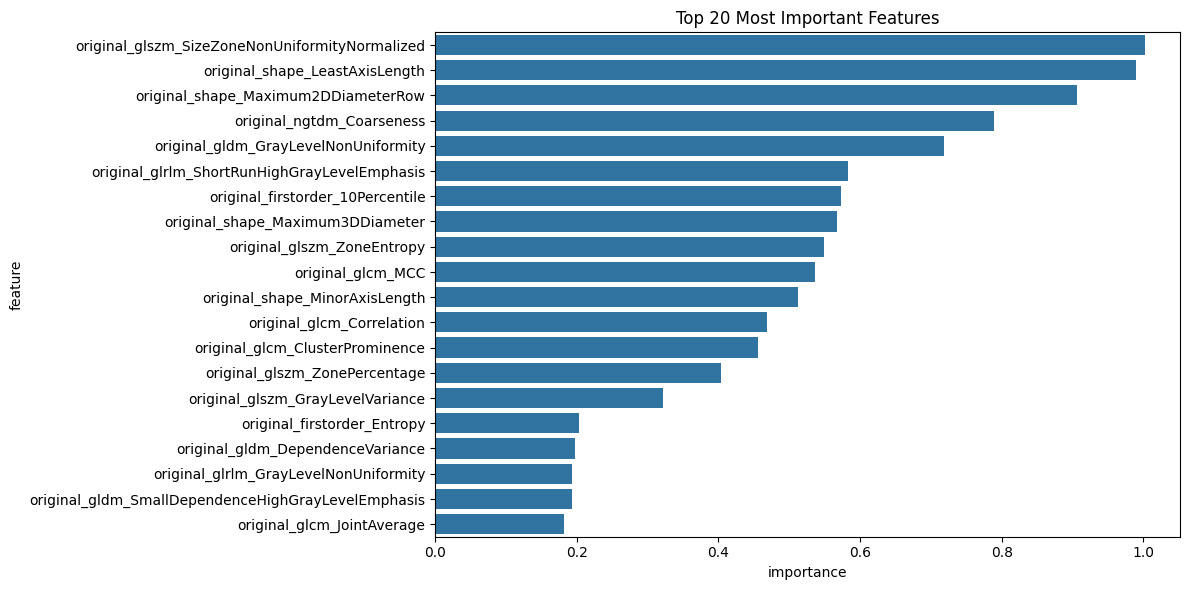

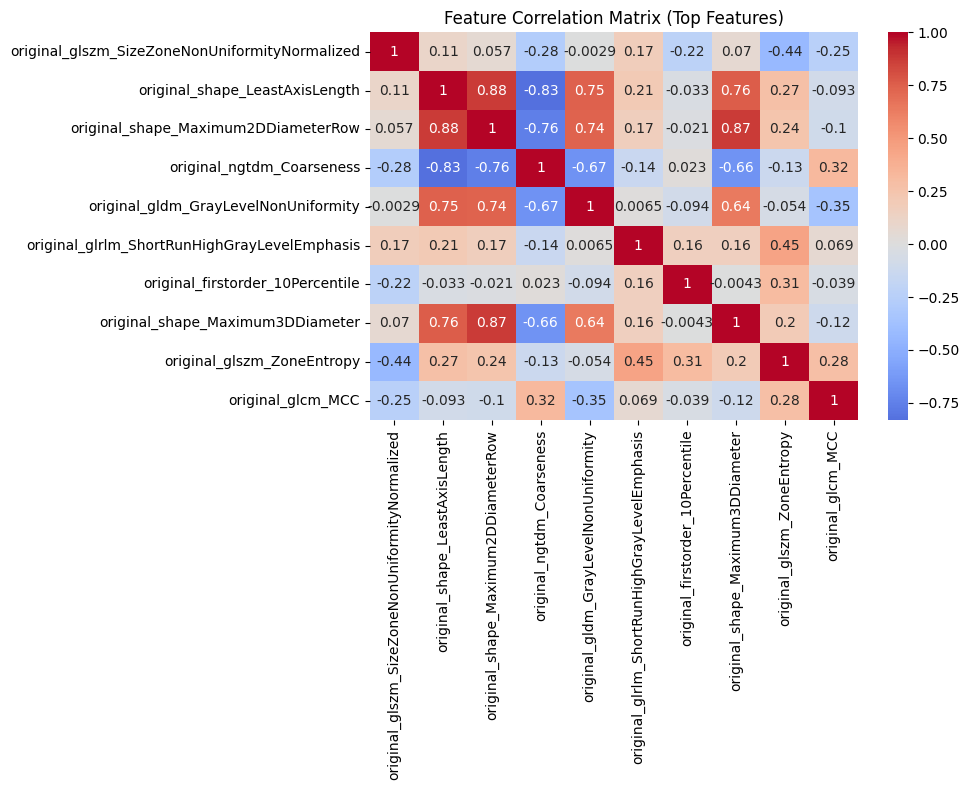

In [8]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_names_after_pipeline(pipeline, original_feature_names):
    """
    获取管道处理后的特征名称
    """
    # 检查是否有特征选择器
    feature_names = np.array(original_feature_names)
    
    # 遍历管道中的每个步骤
    for name, step in pipeline.named_steps.items():
        # 跳过最后的分类器
        if name == 'classifier':
            continue
            
        # 如果步骤有get_feature_names_out方法
        if hasattr(step, 'get_feature_names_out'):
            feature_names = step.get_feature_names_out()
        # 如果步骤有get_support方法（特征选择器）
        elif hasattr(step, 'get_support'):
            mask = step.get_support()
            feature_names = feature_names[mask]
            
    return feature_names

def analyze_model_importance(pipeline, feature_names, X, y, model_type='linear'):
    """
    分析模型特征重要性
    """
    # 获取管道处理后的特征名称
    final_feature_names = get_feature_names_after_pipeline(pipeline, feature_names)
    
    if model_type == 'linear':
        # 对于线性模型（如逻辑回归）
        model = pipeline.named_steps['classifier']
        try:
            # 获取系数
            importances = np.abs(model.coef_[0])
            if len(importances) != len(final_feature_names):
                print(f"Warning: Feature names length ({len(final_feature_names)}) "
                      f"doesn't match importance length ({len(importances)})")
                final_feature_names = [f'feature_{i}' for i in range(len(importances))]
                
            importance_df = pd.DataFrame({
                'feature': final_feature_names,
                'importance': importances
            })
        except AttributeError:
            # 如果模型没有coef_属性，使用排列重要性
            result = permutation_importance(pipeline, X, y, n_repeats=10)
            importance_df = pd.DataFrame({
                'feature': final_feature_names,
                'importance': result.importances_mean
            })
            
    else:  # 树模型
        model = pipeline.named_steps['classifier']
        try:
            importances = model.feature_importances_
            std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
            if len(importances) != len(final_feature_names):
                print(f"Warning: Feature names length ({len(final_feature_names)}) "
                      f"doesn't match importance length ({len(importances)})")
                final_feature_names = [f'feature_{i}' for i in range(len(importances))]
                
            importance_df = pd.DataFrame({
                'feature': final_feature_names,
                'importance': importances,
                'std': std
            })
        except AttributeError:
            # 如果模型没有feature_importances_属性，使用排列重要性
            result = permutation_importance(pipeline, X, y, n_repeats=10)
            importance_df = pd.DataFrame({
                'feature': final_feature_names,
                'importance': result.importances_mean,
                'std': result.importances_std
            })

    return importance_df.sort_values('importance', ascending=False)

def comprehensive_model_interpretation(pipeline, X_train, y_train, X_val, y_val, feature_names, model_type='linear'):
    """
    综合模型解释
    """
    print("=== 开始模型解释分析 ===")
    
    # 1. 基础模型性能评估
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    print(f"\nModel AUC Score: {auc_score:.4f}")

    # 2. 特征重要性分析
    importance_df = analyze_model_importance(pipeline, feature_names, X_val, y_val, model_type)
    
    # 3. 可视化重要特征
    plt.figure(figsize=(12, 6))
    top_n = min(20, len(importance_df))
    sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

    # 4. 特征相关性分析
    try:
        top_features = importance_df['feature'].head(min(10, len(importance_df))).tolist()
        available_features = [f for f in top_features if f in X_train.columns]
        if available_features:
            correlation_matrix = X_train[available_features].corr()
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
            plt.title('Feature Correlation Matrix (Top Features)')
            plt.tight_layout()
            plt.show()
        else:
            print("Warning: Could not generate correlation matrix due to feature name mismatch")
    except Exception as e:
        print(f"Warning: Could not generate correlation matrix: {str(e)}")

    return importance_df

# 使用示例：
results_lr = comprehensive_model_interpretation(
    pipeline,
    X_train, y_train,
    X_val, y_val,
    np.array(X_train.columns),
    model_type='linear'
)